<a href="https://colab.research.google.com/github/SouvikUMD/Leaf-Disease-Prediction/blob/main/fpgaannsnnmodels_anntosnnfpgasimulation_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

Background
This is combined code of the software of FPGA-friendly SNN models inspired by the following link here [1]. The following code below follows the steps shown in [1]. First the network is simulated to get the approximate integer weights. Next, the weights are extracted from the network and converted into 16 bit hex values. Finally, the original weights are tested with the original test data and the classification accuracy is evaluated. PyTorch and BindsNET packages are utilized below. New Features add to this version are hidden neuron connections and outputs which will be used for the FPGA board. For this notebook, the 16-bit hex weights are tested with the original data. The outputs of the train and test data are provided using outputs_training.txt and outputs_test.txt respectively.

[1] https://github.com/oshears/fpga_snn_models/tree/main.

# Set Up Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

## Install Libraries

In [ ]:
!ls fpga_snn_models/models/*.py

fpga_snn_models/models/diehl_cook_snn.py  fpga_snn_models/models/__init__.py
fpga_snn_models/models/if_snn.py


In [ ]:
!cat 'fpga_snn_models/models'

cat: fpga_snn_models/models: Is a directory


In [ ]:
import sys
path_name = '/content/drive/My Drive/Colab Notebooks/fpga_snn_models/'
sys.path.append('fpga_snn_models/models')
os.chdir(f'{path_name}models')

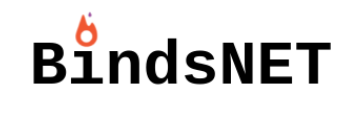

BindsNET is built on top of PyTorch platform. It is used for the simulation of SNNs and is geared towards machine learning and reinforcement learning. The BindsNet installation taken from [2]. Documentation Explanations for BindsNET are shown in [3].

[2] https://github.com/BindsNET/bindsnet.

[3] https://bindsnet-docs.readthedocs.io/

In [ ]:
!pip install git+https://github.com/BindsNET/bindsnet.git

  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-volwhiwn
  Running command git clone --filter=blob:none --quiet https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-volwhiwn
  Resolved https://github.com/BindsNET/bindsnet.git to commit 0956fa8e029ef5e1e7257cb43ea2210a7260ce51
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.8 MB/s eta

In [ ]:
# import numpy
import numpy as np

# import modules from pytorch
import torch
from torchvision import transforms

# import local modules
from diehl_cook_snn import DiehlAndCookNetwork16,DiehlAndCookNetwork32
from if_snn import IFNetwork16,IFNetwork32

# miscellaneous imports
import argparse

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image # PIL is the Python Imaging Library
import random

In [ ]:
# import modules from bindsnet
from bindsnet.datasets import MNIST, DataLoader, CIFAR10
from bindsnet.encoding import PoissonEncoder,BernoulliEncoder,RankOrderEncoder
from bindsnet.evaluation import all_activity,proportion_weighting,assign_labels
from bindsnet.network.monitors import Monitor
from bindsnet.network import load

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Create Argument Parser for Specific Encoding

In [ ]:
# create an argument parser to interpret command line arguments
parser = argparse.ArgumentParser()

# --encoding specifies the type of encoding (Poisson, Bernoulli or RankOrder)
parser.add_argument("--encoding", type=str, default="Poisson")
#parser.add_argument("--encoding", type=str, default="Bernoulli")
#parser.add_argument("--encoding", type=str, default="RankOrder")
parser.add_argument("--weight_size", type=int, default=32)
parser.add_argument("--neuron_type", type=str, default="IF")
#parser.add_argument("--neuron_type", type=str, default="diehlAndCook")
parser.add_argument("--batch_size", type=int, default=256)

# parse the arguments
#args = parser.parse_args()
args, unknown = parser.parse_known_args()

# Declare Global Variables.

In [ ]:
# batch_size specifies the number of training samples to collect weight changes
# from before updating the weights.
batch_size = args.batch_size
print(f"Batch Size: {batch_size}")

# n_train specifies the number of training samples
#n_train = 60000
#n_train = 56000
#n_train = 49000
n_train = 5600

# n_test specifies the number of testing samples
#n_test = 10000
#n_test = 14000
#n_test = 21000
n_test = 1400

# update_steps specifies the number of batches to process before reporting
# an update.
update_steps = 10

# time specifies the simulation time of the SNN
time = 100

# dt specifies the timestep size for the simulation time
dt = 1

# n_neurons specifies the number of neurons per layer
n_neurons = 10

# intensity specifies the maximum intensity of the input data
intensity = 128

# gpu setting
gpu = torch.cuda.is_available()
print(f"GPU: {gpu}")

# update_interavl specifies the number of samples processed before updating
# accuracy estimations.
update_interval = update_steps * batch_size

# setup CUDA
device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu")

# determine number of worker threads to load data
n_workers = 1
# if n_workers == -1:
#     n_workers = gpu * 4 * torch.cuda.device_count()

# report the selected encoding scheme, neural model and learning technique
print("Encoding Scheme:",args.encoding)

# assign a value to the encoder based on the input argument
encoder = None
if args.encoding == "Poisson":
    encoder = PoissonEncoder(time=time,dt=dt)
if args.encoding == "Bernoulli":
    encoder = BernoulliEncoder(time=time,dt=dt)
if args.encoding == "RankOrder":
    encoder = RankOrderEncoder(time=time,dt=dt)

# build network based on the input argument
print(f"Neuron Model: {args.neuron_type}")
print(f"Weight Size: {args.weight_size}")
neuron_type = ""
if args.neuron_type == "IF":
    neuron_type = "if"
else:
    neuron_type = "diehlAndCook"


# Build Network Based on the Input Argument.
#networkFile = f"{path_name}networks/{neuron_type}_Poisson_{batch_size}_{args.weight_size}bit_snn.pt"
networkFile = f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn.pt"
# Build Weights Directory.
#weightFileDirectory = f"{path_name}networks/{neuron_type}_Poisson_{batch_size}_{args.weight_size}bit_weights"
weightFileDirectory = f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_weights"
#weightFileDirectory = f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_weights_onelayer"
#weightFileDirectory = f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_weights_25layers"


network = None
assignments = None
proportions = None

# Run the network using the GPU/CUDA
if gpu:
    #network = load(f"{path_name}networks/{neuron_type}_Poisson_{batch_size}_{args.weight_size}bit_snn.pt")
    #assignments = torch.load(f'{path_name}networks/{neuron_type}_Poisson_{batch_size}_{args.weight_size}bit_snn_assignments.pt')
    #proportions = torch.load(f'{path_name}networks/{neuron_type}_Poisson_{batch_size}_{args.weight_size}bit_snn_proportions.pt')
    network = load(f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn.pt")
    assignments = torch.load(f'{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn_assignments.pt')
    proportions = torch.load(f'{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn_proportions.pt')
else:
    #network = load(f"{path_name}networks/{neuron_type}_Poisson_{batch_size}_{args.weight_size}bit_snn.pt",map_location=torch.device('cpu'))
    #assignments = torch.load(f'{path_name}networks/{neuron_type}_Poisson_{batch_size}_{args.weight_size}bit_snn_assignments.pt',map_location=torch.device('cpu'))
    #proportions = torch.load(f'{path_name}networks/{neuron_type}_Poisson_{batch_size}_{args.weight_size}bit_snn_proportions.pt',map_location=torch.device('cpu'))
    network = load(f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn.pt",
                   map_location=torch.device('cpu'))
    assignments = torch.load(f'{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn_assignments.pt',
                             map_location=torch.device('cpu'))
    proportions = torch.load(f'{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn_proportions.pt',
                             map_location=torch.device('cpu'))

proportions = proportions.view(1,n_neurons)

# Set to GPU if needed.
if gpu:
    assignments = assignments.cuda()
    proportions = proportions.cuda()

# Update weights based on the FPGA values.
# Extract connections.
excitatoryConnectionWeights = network.connections["X","Y"].w

Batch Size: 256
GPU: False
Encoding Scheme: Poisson
Neuron Model: IF
Weight Size: 32


# Test the Adjusted Weights

In [ ]:
# for each hidden layer neuron
for neuronIdx in range(excitatoryConnectionWeights.shape[1]):
    # new file
    neuronFile = open(f"{weightFileDirectory}/{neuronIdx}.txt","r")

    # for each input neuron
    for inputIdx in range(excitatoryConnectionWeights.shape[0]):
        # read the weight value from the file
        hexWeightValue = neuronFile.readline().strip()
        print("hexWeightValue: ", hexWeightValue)
        weightValue = int(hexWeightValue,16)
        print("weightValue: ", weightValue)
        #weightValue = hex(hexWeightValue)
        excitatoryConnectionWeights[inputIdx][neuronIdx] = weightValue

    neuronFile.close()


# run the network using the GPU/CUDA
if gpu:
    network.to("cuda")

hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightValue:  0000
weightValue:  0
hexWeightVal

# Load Training and Testing Dataset.

The BindsNET package also comes with different datasets like CIFAR10, ALOV, and MNIST. This code can handle the MNIST dataset. The dimensions of an MNIST image are 28x28 pixels. Before proceeding further beyond the code, please change dim to 28 for access to MNIST datasets in the Variable Setup section located above.

In [ ]:
# Load the MNIST dataset.
train_dataset = MNIST(
    encoder,
    None,
    root=os.path.join(".", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

test_dataset = MNIST(
    encoder,
    None,
    root=os.path.join(".", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Pull n_test random elements from test_dataset.
train_dataset_rnd = random.sample(list(train_dataset.data), n_train)
#train_dataset_rnd = resize_images(train_dataset_rnd)
print(len(train_dataset_rnd))
train_dataset.data = train_dataset_rnd
print("Random sample of Train Data:", train_dataset_rnd)

# create a dataloader to iterate over and batch the training data.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=n_workers,
                              pin_memory=True)

# Pull n_test random elements from test_dataset
test_dataset_rnd = random.sample(list(test_dataset.data), n_test)
#test_dataset_rnd = resize_images(test_dataset_rnd)
test_dataset.data = test_dataset_rnd
print("Random sample of Test Data:", test_dataset_rnd)

# create a dataloader to iterate over and batch the test data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=n_workers, pin_memory=True)

5600
Random sample of Train Data: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Set up Global Variables for Training and Testing.

In [ ]:
# declare variables needed for estimating the network accuracy
n_classes = 10

# create a monitor to record the spiking activity of the output layer (Y)
output_spikes_monitor = Monitor(network.layers["Y"], state_vars=["s"],
                                time=int(time / dt))

# add the monitor to the network
network.add_monitor(output_spikes_monitor, name="Y")

# create a tensor to store the spiking activity for all neurons for the duration of the update_interval
spike_record = torch.zeros((update_interval, int(time / dt), n_neurons),
                           device=device)

# Create a dictionary to store all assignment and proportional assignment
# accuracy values for the test data.
accuracy = {"all": 0, "proportion": 0}

In [ ]:
# Run the network for each test sample.
print("\nBegin training\n")

network.train(mode=False)

# Train Network for 5 epochs.
for i in range(2):
  print(f"Epoch {i + 1}:")
  # Iterate over each batch.
  train_out_file = open(f"{weightFileDirectory}/outputs_training.txt","w")
  for step, batch in enumerate(train_dataloader):
      # Get next input sample.
      inputs = {"X": batch["encoded_image"]}
      #print(input.shape)
      if gpu:
          inputs = {k: v.cuda() for k, v in inputs.items()}

      # Run the network on the input.
      network.run(inputs=inputs, time=time, input_time_dim=100)

      # get the spikes produced by the current batch
      spike_record = output_spikes_monitor.get("s").permute((1, 0, 2))

      # convert the array of labels into a tensor
      label_tensor = torch.tensor(batch["label"], device=device)

      # Get network predictions based on the spiking activity, previous
      # assignments and number of classes.
      all_activity_pred = all_activity(spikes=spike_record,
                                      assignments=assignments,
                                        n_labels=n_classes)

      # Get network predictions based on the spiking activity, previous
      # assignments, proportional assignments and number of classes.
      proportion_pred = proportion_weighting(spikes=spike_record,
                                            assignments=assignments,
                                            proportions=proportions,
                                            n_labels=n_classes)

      # Compute the network accuracy based on the prediction results and add the
      # results to the accuracy dictionary.
      accuracy["all"] += float(torch.sum(label_tensor.long() ==
                                        all_activity_pred).item())

      # Compute the network accuracy based on the proportional prediction
      # results and add the results to the accuracy dictionary.
      accuracy["proportion"] += float(torch.sum(label_tensor.long() ==
                                                proportion_pred).item())


      print(f"all activity: {all_activity_pred}\n")
      all_activity_pred = all_activity_pred.numpy()
      train_out_file.write(f"all activity: {all_activity_pred}\n")
      print(f"proportion activity: {proportion_pred}\n")
      proportion_pred = proportion_pred.numpy()
      train_out_file.write(f"proportion activity: {proportion_pred}\n")

      # reset the network before running it again
      network.reset_state_variables()


# print out the final assignment and proportional assignment accuracies
print("\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test))
print("Proportion weighting accuracy: %.2f \n"
      % (accuracy["proportion"] / n_test))
print("Training complete.\n")


Begin training

Epoch 1:
all activity: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

proportion activity: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
 

In [ ]:
# run the network for each test sample
print("\nBegin testing\n")

test_out_file = open(f"{weightFileDirectory}/outputs_test.txt","w")
# iterate over each batch
for step, batch in enumerate(test_dataloader):
  # get next input sample
  inputs = {"X": batch["encoded_image"]}
  #print(input.shape)
  if gpu:
      inputs = {k: v.cuda() for k, v in inputs.items()}

  # run the network on the input
  network.run(inputs=inputs, time=time, input_time_dim=100)

  # get the spikes produced by the current batch
  spike_record = output_spikes_monitor.get("s").permute((1, 0, 2))

  # convert the array of labels into a tensor
  label_tensor = torch.tensor(batch["label"], device=device)

  # get network predictions based on the spiking activity, previous
  # assignments and number of classes.
  all_activity_pred = all_activity(spikes=spike_record,
                                  assignments=assignments,
                                    n_labels=n_classes)

  # get network predictions based on the spiking activity, previous
  # assignments, proportional assignments and number of classes.
  proportion_pred = proportion_weighting(spikes=spike_record,
                                        assignments=assignments,
                                        proportions=proportions,
                                        n_labels=n_classes)

  # compute the network accuracy based on the prediction results and add the
  # results to the accuracy dictionary.
  accuracy["all"] += float(torch.sum(label_tensor.long() ==
                                    all_activity_pred).item())

  # compute the network accuracy based on the proportional prediction results
  # and add the results to the accuracy dictionary.
  accuracy["proportion"] += float(torch.sum(label_tensor.long() ==
                                            proportion_pred).item())

  print(f"all activity: {all_activity_pred}\n")
  all_activity_pred = all_activity_pred.numpy()
  test_out_file.write(f"all activity: {all_activity_pred}\n")
  print(f"proportion activity: {proportion_pred}\n")
  proportion_pred = proportion_pred.numpy()
  test_out_file.write(f"proportion activity: {proportion_pred}\n")

  # if it is time to print out an accuracy estimate
  if step % update_steps == 0 and step > 0:
      # print out the assignment and proportional assignment accuracy
      print("\nAll activity accuracy: %.2f"
            % (accuracy["all"] / (step*256)))
      print("Proportion weighting accuracy: %.2f"
            % (accuracy["proportion"] / (step*256)))

      #print out how many test samples are remaining
      print("Progress:",step*batch_size,"/",n_test)

  # reset the network before running it again
  network.reset_state_variables()


# print out the final assignment and proportional assignment accuracies
print("\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test))
print("Proportion weighting accuracy: %.2f \n"
      % (accuracy["proportion"] / n_test))
print("Testing complete.\n")


Begin testing

all activity: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

proportion activity: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 